# Decision Trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
iris = load_iris()

plt.rcParams["figure.figsize"] = (8, 5)

In [2]:
iris = load_iris()
X, y = iris.data[:,2:], iris.target
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=314)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best')

In [18]:
def plot_decision_function(X, y, model):
    x1min, x2min = X.min(axis=0) * 0.7
    x1max, x2max = X.max(axis=0) * 1.1

    x1map, x2map = np.mgrid[x1min:x1max:0.01, x2min:x2max:0.01]
    xpred = np.c_[x1map.reshape(-1,1), x2map.reshape(-1,1)]
    ypred = model.predict(xpred).reshape(x1map.shape)
    plt.contourf(x1map, x2map, ypred, alpha=0.3)
    plt.scatter(*X.T, c=y)


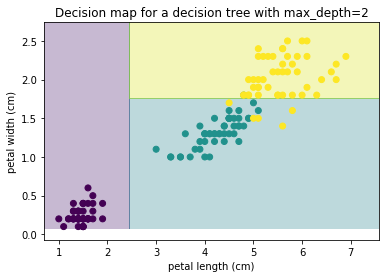

In [20]:
plot_decision_function(X, y, tree_clf)
plt.title(f"Decision map for a decision tree with max_depth={max_depth}")
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3]);

> Traversing the Decision Tree requires going through roughly $O(\log_2(m))$ nodes

In [4]:
np.log2(iris["target"].shape[0])

7.2288186904958804

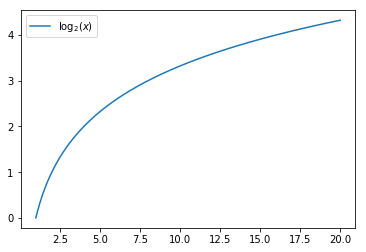

In [5]:
xrange = np.linspace(1, 20, 500)
plt.plot(xrange, np.log2(xrange), label="$\log_2(x)$")
plt.legend()
plt.show()

In [6]:
# Probability of a classification is the "impurity" when classifying
tree_clf.predict_proba([[5, 1.5]]), tree_clf.predict_proba([[5, 1]])

(array([[ 0.        ,  0.90740741,  0.09259259]]),
 array([[ 0.        ,  0.90740741,  0.09259259]]))

In [7]:
export_graphviz(
    tree_clf,
    out_file="./images/iris_tree.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [8]:
%%bash
dot -Tpng "./images/iris_tree.dot" -o "./images/iris_tree.png"

<img style="center" src="./images/iris_tree.png">

In [20]:
g1 = 1 - ((0 / 54) ** 2 + (49 / 54) ** 2 + (5 / 54) ** 2)
print(f"Gini score for bottom left leaf: {g1:0.5f}")

Gini score for bottom left leaf: 0.16804


## Exercises

**1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with 1 million instances?**

The approximate depth of a Decisión tree is $O(\log(m))$. Therefore, the depth of a decision tree trained on 1 million instances would be approximately $\log(1,000,000) \approx 19.93$

---
**2. Is a node’s Gini impurity generally lower or greater than its parent’s? Is it generally lower/greater, or always lower/greater?**

The purity in a node of a tree, considering the Gini impurity, is **generally** *lower* than its parents.

---
**3. If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?**


**Train and fine-tune a Decision Tree for the moons dataset**
1. Generate a moons dataset using `make_moons(n_samples=10_000, noise=0.4)`
2. Split it into a training set and test set using `train_test_split()`
3. Use grid-search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [53]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

moons = make_moons(n_samples=10_000, noise=0.4, random_state=1643)
features, labels = moons
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.2)

In [169]:
hparams = {"max_leaf_nodes": list(range(2, 20))}
tree_clf = GridSearchCV(DecisionTreeClassifier(), hparams, cv=10)
tree_clf.fit(xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [170]:
format(tree_clf.best_score_, "0.2%")

'85.80%'

In [171]:
tree_clf.best_params_

{'max_leaf_nodes': 16}

In [180]:
np.mean(tree_clf.predict(xtest) == ytest)

0.85950000000000004

**Grow a Forest**

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use ScikitLearn’s `ShuffleSplit` class for this.

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

c. **The magic forest**. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This gives you majority-vote predictions over the test set.

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher).

In [186]:
from sklearn.model_selection import ShuffleSplit
shsplit = ShuffleSplit(n_splits=1000, train_size=100,
                       test_size=800, random_state=314)

In [194]:
test_split_scores = []

# Empty list to save all model instances (to be used a test)
decision_trees = []
# One thousand instances; each of which contains
# 100 training instances and 800 test instances
for split in shsplit.split(xtrain, ytrain):
    train_ix, test_ix = split
    split_x_train = xtrain[train_ix]
    split_y_train = ytrain[train_ix]
    tree_split_clf = DecisionTreeClassifier(**tree_clf.best_params_)
    tree_split_clf.fit(split_x_train, split_y_train)
    decision_trees.append(tree_split_clf)
    
    test_score = tree_split_clf.score(xtest, ytest)
    test_split_scores.append(test_score)

mean_test_score = np.mean(test_split_scores)
print(f"Average score on test {mean_test_score:0.3%}")

Average score on test 79.964%


Very low-efficient implementation of a random-forest classifier.

In [197]:
from scipy.stats import mode

random_forest_preds = []
# For each training point in the test set, we consider
# every prediction for each of the 1,000 models and compute
# the mode of the restul
for xtslice in xtest:
    model_preds = []
    for model in decision_trees:
        slice_pred = model.predict(xtslice.reshape(1, -1))
        model_preds.append(slice_pred[0])
    random_forest_preds.append(mode(model_preds).mode[0])

**-- The Random Forest --**

In [202]:
from sklearn.metrics import accuracy_score

acc_decision_tree = accuracy_score(tree_clf.predict(xtest), ytest)
acc_random_forest = accuracy_score(random_forest_preds, ytest)

print(f"Final accuracy for a decision tree: {acc_decision_tree:0.2%}")
print(f"Final accuracy for a random forest: {acc_random_forest:0.2%}")

Final accuracy for a decision tree: 85.95%
Final accuracy for a random forest: 86.20%


---
## Some notes on the big-$O$ notation
By [Rob Bell](https://rob-bell.net/2009/06/a-beginners-guide-to-big-o-notation/)

In [65]:
randn_small = np.random.randn(10)
randn_big = np.random.randn(100_000)

>Big O specifically describes the worst-case scenario, and can be used to describe the execution time required or the space used (e.g. in memory or on disk) by an algorithm.m

> $O(1)$ describes an algorithm that will always execute in the same time (or space) regardless of the size of the input data set.

In [54]:
def is_first_zero(array):
    return array[0] == 0

In [66]:
%%timeit -n 30
is_first_zero(randn_small)

463 ns ± 104 ns per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [67]:
%%timeit -n 30
is_first_zero(randn_big)

461 ns ± 97.5 ns per loop (mean ± std. dev. of 7 runs, 30 loops each)


> $O(N)$ describes an algorithm whose performance will grow linearly and in direct proportion to the size of the input data set.

For the follwing scenario, even though the program might return `True` before visiting every value in the array, we consider **the worst case scenario**

In [52]:
def array_has_value(array, value):
    for val in array:
        if val == value:
            return True
    return False

In [71]:
%%timeit -n 30
array_has_value(randn_small, 3)

3.87 µs ± 448 ns per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [72]:
%%timeit -n 30
array_has_value(randn_big, 3)

18.4 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


> $O(N^2)$ represents an algorithm whose performance is directly proportional to the square of the size of the input data set.

Common when iterating the same list twice

In [76]:
def has_duplicates(array):
    for ix1, el1 in enumerate(array):
        for ix2, el2 in enumerate(array):
            if (el1 == el2) and (ix1 != ix2):
                return True
    return False

> $O(2^N)$ denotes an algorithm whose growth doubles with each additon to the input data set. 

in the following example, once we start with a number, it creates a tree with two nodes, each one of those nodes create another two nodes and so on. Totalling $2^N$ values

In [79]:
def fibo(number):
    if number <= 1:
        return number
    else:
        return fibo(number - 2) + fibo(number - 1)

In [97]:
format(2 ** 1, ",")

'2'

In [95]:
format(2 ** 10, ",")

'1,024'

In [96]:
format(2 ** 100, ",")

'1,267,650,600,228,229,401,496,703,205,376'

In [98]:
format(2 ** 1000, ",")

'10,715,086,071,862,673,209,484,250,490,600,018,105,614,048,117,055,336,074,437,503,883,703,510,511,249,361,224,931,983,788,156,958,581,275,946,729,175,531,468,251,871,452,856,923,140,435,984,577,574,698,574,803,934,567,774,824,230,985,421,074,605,062,371,141,877,954,182,153,046,474,983,581,941,267,398,767,559,165,543,946,077,062,914,571,196,477,686,542,167,660,429,831,652,624,386,837,205,668,069,376'

> $O(\log n)$

In [102]:
np.log10(10)

1.0

In [103]:
np.log10(100)

2.0

In [104]:
np.log10(1000)

3.0

In [105]:
np.log10(100000)

5.0